In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split  
from sklearn import preprocessing
import optuna 
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score,precision_score, confusion_matrix,recall_score
from sklearn.model_selection import cross_val_score, train_test_split
import os 

In [2]:
train_data=pd.read_csv('/home/iai/son/lastcheck/spambase_train_data.csv')
test_data=pd.read_csv('/home/iai/son/lastcheck/spambase_test_data.csv')

In [3]:
train_stage_features=['0.7', '278', '61', '0', '0.34', '0.30', '0.5', '0.44', '0.40', '0.778',
                        '0.24', '1.93', '0.39', '1.29', '0.43', '0.2', '0.36', '0.17', '0.20', 
                        '0.28', '0.21', '0.32.1', '0.41', '0.29', '3.756', '0.35', '0.25', '0.15', 
                        '0.64.1', '0.38', '0.45', '0.6', '0.33', '0.42', '0.14', '0.9', '0.10', 
                        '0.3', '0.13', '0.8', '0.19', '0.23', '0.18', '0.22', '0.16', '0.64.2', 
                        '0.1', '0.31', '0.27', '0.11', '0.4', '0.12', '0.26', '0.64', '0.37', '0.32', '0.96']
test_stage_features=['0.7', '278', '61', '0', '0.34', '0.30', '0.5', '0.44', '0.40', '0.778',
                        '0.24', '1.93', '0.39', '1.29', '0.43', '0.2', '0.36', '0.17', '0.20']

In [4]:
train_X=train_data.loc[:,train_stage_features]
train_y=train_data['1']
new_test_data_X=test_data.loc[:,test_stage_features]
new_test_data_y=test_data['1']

In [5]:
ratio=train_y.value_counts()[0]/train_y.value_counts()[1]

In [6]:
onlytrain_X=train_X.loc[:,[ '0.28', '0.21', '0.32.1', '0.41', '0.29', '3.756', '0.35', '0.25', '0.15', 
                        '0.64.1', '0.38', '0.45', '0.6', '0.33', '0.42', '0.14', '0.9', '0.10', 
                        '0.3', '0.13', '0.8', '0.19', '0.23', '0.18', '0.22', '0.16', '0.64.2', 
                        '0.1', '0.31', '0.27', '0.11', '0.4', '0.12', '0.26', '0.64', '0.37', '0.32', '0.96']]

In [7]:
from sklearn.decomposition import PCA 
pca=PCA()
pca.fit(onlytrain_X)
X_pca=pca.transform(onlytrain_X)

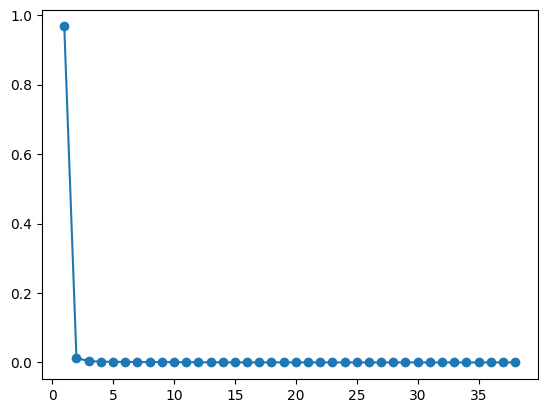

In [8]:
# Scree plot 그리기

plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_,marker='o')

In [9]:
from sklearn.decomposition import PCA 
pca=PCA(n_components=4)
pca.fit(onlytrain_X)
X_pca=pca.transform(onlytrain_X)

In [10]:
pca_columns=['pca_component1','pca_component2','pca_component3','pca_component4']
onlytrain_pca=pd.DataFrame(X_pca,columns=pca_columns)

In [11]:
onlytrain_pca

,pca_component1,pca_component2,pca_component3,pca_component4
0,0.478035,-0.773962,-0.453098,-0.152162
1,-1.067603,-0.707938,-0.361943,-0.075671
2,-3.495102,0.659180,-0.398420,-0.052525
3,-0.792114,-0.736706,1.777176,-0.021672
4,0.558370,-0.763537,-0.629529,-0.071074
...,...,...,...,...
3675,0.142169,-0.831408,-1.115872,-0.081175
3676,2.260771,-0.807889,-0.713248,-0.102740
3677,-3.217072,-0.862624,-1.020785,-0.379617
3678,-3.961853,0.501745,-0.381293,-0.077506


In [12]:
train_X=train_data[test_stage_features] 

In [13]:
new_train_X=pd.concat([train_X,onlytrain_pca],axis=1)

In [14]:
def objective(trial):
    # Define hyperparameters to optimize 
    params={
        'boosting_type':'gbdt',
        'objective':'binary',
        'metric':'binary_logloss',
        'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
        'max_depth':trial.suggest_int('max_depth',3,9),
        'n_estimators':trial.suggest_int("n_estimators",100,1000)
    }
    # Train and evaluate model 
    lgb_cv=lgb.LGBMClassifier(**params, random_state=42,scale_pos_weight=ratio)
    scores=cross_val_score(lgb_cv,new_train_X,train_y,cv=5,scoring='roc_auc')
    auc=scores.mean()
    return auc 

# Define study object and optimize 

study=optuna.create_study(direction='maximize',study_name='lgb_boost_opt',load_if_exists=True)
study.optimize(objective, n_trials=50)

# Print best hyperparameters and auc
print(f'Best hyperparameters: {study.best_params}')
print(f'Best AUC: {study.best_value:.4f}')

[I 2023-04-26 15:52:38,679] A new study created in memory with name: lgb_boost_opt
/tmp/ipykernel_1373733/14971935.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
[I 2023-04-26 15:52:39,420] Trial 0 finished with value: 0.9759106397539019 and parameters: {'learning_rate': 0.026465460877371054, 'max_depth': 3, 'n_estimators': 364}. Best is trial 0 with value: 0.9759106397539019.
/tmp/ipykernel_1373733/14971935.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
[I 2023-04-26 15:52:40,150] Trial 1 finished wi

Best hyperparameters: {'learning_rate': 0.08237179316845265, 'max_depth': 7, 'n_estimators': 655}
Best AUC: 0.9830


In [15]:
lgb=lgb.LGBMClassifier(learning_rate= 0.08237179316845265,max_depth= 7,n_estimators=655,scale_pos_weight=ratio,random_state=42)

In [16]:
lgb.fit(new_train_X,train_y)

LGBMClassifier(learning_rate=0.08237179316845265, max_depth=7, n_estimators=655,
               random_state=42, scale_pos_weight=1.5879043600562588)

In [17]:
train_prob=pd.DataFrame()
train_prob['prob']=lgb.predict_proba(new_train_X)[:,1]

In [18]:
train_prob['1_prob']=1-train_prob['prob']
train_prob['odds']=train_prob['prob']/train_prob['1_prob']

In [19]:
train_prob['loogits']=np.log(train_prob['odds'])
train_X_new=new_train_X[test_stage_features]

In [20]:
import optuna
from lightgbm import LGBMRegressor

# Objective 함수 정의
def objective(trial):
    
    # 하이퍼파라미터 탐색할 공간 정의
    params = {
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        'max_depth': trial.suggest_int('max_depth',3,9),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.01,0.1),
    }
    
    # LGBMRegressor 모델 객체 생성
    model = LGBMRegressor(**params, random_state=42)
    
    # 교차검증 수행하여 모델 성능 측정
    scores = -1 * cross_val_score(model, train_X_new, train_prob['loogits'],
                                  cv=5, scoring='neg_mean_squared_error')
    
    # 교차검증 평균 점수 리턴
    return np.mean(scores)


# Optuna study 생성
study = optuna.create_study(direction='minimize')

# study 실행 (n_trials는 시도 횟수)
study.optimize(objective, n_trials=50)

# 최적화된 하이퍼파라미터 값 출력
print(study.best_params)

[I 2023-04-26 15:56:52,366] A new study created in memory with name: no-name-66803dc7-7155-4b04-ac87-22caab6ad936
/tmp/ipykernel_1373733/4075368247.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate',0.01,0.1),
[I 2023-04-26 15:56:53,853] Trial 0 finished with value: 29.864091175456462 and parameters: {'n_estimators': 451, 'max_depth': 9, 'learning_rate': 0.010908242189178848}. Best is trial 0 with value: 29.864091175456462.
/tmp/ipykernel_1373733/4075368247.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate',0.01,0.1),
[I 2023-

{'n_estimators': 790, 'max_depth': 9, 'learning_rate': 0.034392642354376286}


In [21]:
# Print best hyperparameters and auc

print(f'Best hyperparameters: {study.best_params}')
print(f'Best RMSE: {study.best_value:.4f}')

Best hyperparameters: {'n_estimators': 790, 'max_depth': 9, 'learning_rate': 0.034392642354376286}
Best RMSE: 27.3119


In [22]:
model = LGBMRegressor(n_estimators=790,max_depth= 9,learning_rate= 0.034392642354376286)

In [23]:
model.fit(train_X_new,train_prob['loogits'])

LGBMRegressor(learning_rate=0.034392642354376286, max_depth=9, n_estimators=790)

In [24]:
test_data=pd.DataFrame()
test_data['loogits']=model.predict(new_test_data_X)

In [25]:
test_data['new_prob']=1/(1+np.exp(-test_data['loogits']))

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_prob(y_test, probability):
  pred=np.where(probability > 0.5,1,0)
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred) 
  recall=recall_score(y_test,pred) 
  # F1 스코어 추가 
  f1=f1_score(y_test,pred,average='macro')
  Roc_score=roc_auc_score(y_test,probability)
  print('임계값: ', 0.5) 
  print('오차행렬')
  print(confusion) 
  # f1 score print 추가 
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4: .4f}'.format(accuracy,precision,recall,f1,Roc_score))

In [27]:
get_clf_prob(new_test_data_y,test_data['new_prob'])

임계값:  0.5
오차행렬
[[507  23]
 [ 77 313]]
정확도: 0.8913, 정밀도: 0.9315, 재현율: 0.8026, F1:0.8862, AUC: 0.9522
